In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        if isinstance(names, str):
            names = (names,)

        shape = tf.shape(tensor)
        rank = tf.rank(tensor)

        if rank != len(names):
            raise ValueError(f'Rank mismatch:\n'
                             f'    found {rank}: {shape.numpy()}\n'
                             f'    expected {len(names)}: {names}\n')

        for i, name in enumerate(names):
            if isinstance(name, int):
                old_dim = name
            else:
                old_dim = self.shapes.get(name, None)
            new_dim = shape[i]

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

In [4]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent / 'spa-eng/spa.txt'

In [5]:
def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]

    return targ, inp

In [6]:
targ, inp = load_data(path_to_file)
print(inp[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [7]:
print(targ[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [8]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [9]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'Despu\xc3\xa9s de haber encontrado su n\xc3\xbamero de tel\xc3\xa9fono, \xc3\xa9l la llam\xc3\xb3.'
 b'Tom sabe d\xc3\xb3nde est\xc3\xa1 escondido el dinero.'
 b'Mi esposa no se levanta antes que yo.' b'Veamos si podemos ayudarle.'
 b'Le estamos perdiendo.'], shape=(5,), dtype=string)

tf.Tensor(
[b'After he had found her phone number, he called her up.'
 b'Tom knows where the money is hidden.'
 b"My wife doesn't get up before me." b"Let's see if we can help you."
 b"We're losing it."], shape=(5,), dtype=string)


In [10]:
example_text = tf.constant("¿Todavía está en casa?")

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, "NFKD").numpy())


b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [11]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, "NFKD")
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, "[^ a-z.?!,¿]", "")
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, "[.?!,¿]", r" \0 ")
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(["[START]", text, "[END]"], separator=" ")
    return text


In [12]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())


¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [13]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size
)


In [14]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]


['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [15]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size
)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]


['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [16]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]


<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,  180,    6,  141, 1001,   25,  463,    6,  283,   19],
       [   2,   10,  117,   71,   20, 2777,    7,   93,    4,    3],
       [   2,   24,  437,    9,   17, 1516,  130,    5,   39,    4]],
      dtype=int64)>

In [17]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
" ".join(tokens)


'[START] despues de haber encontrado su numero de telefono , el la llamo . [END]'

Text(0.5, 1.0, 'Mask')

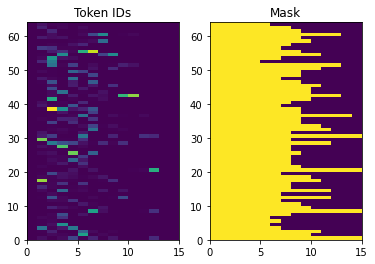

In [18]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title("Token IDs")

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title("Mask")


In [19]:
embedding_dim = 256
units = 1024


In [20]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(
            self.enc_units,
            # Return the sequence and state
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )

    def call(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ("batch", "s"))

        # 2. The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)
        shape_checker(vectors, ("batch", "s", "embed_dim"))

        # 3. The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ("batch", "s", "enc_units"))
        shape_checker(state, ("batch", "enc_units"))

        # 4. Returns the new sequence and its state.
        return output, state


In [21]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f"Input batch, shape (batch): {example_input_batch.shape}")
print(f"Input batch tokens, shape (batch, s): {example_tokens.shape}")
print(f"Encoder output, shape (batch, s, units): {example_enc_output.shape}")
print(f"Encoder state, shape (batch, units): {example_enc_state.shape}")


Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 15)
Encoder output, shape (batch, s, units): (64, 15, 1024)
Encoder state, shape (batch, units): (64, 1024)
